## Anomaly Detection - How do we know if the generated output is similar to Pratchett's style of writing or not?

We know that Pratchett's style of writing has a distinct tone - witty, satirical and rich in metaphor.

How can we measure if our chatbot's outputs will be able to mimic Pratchett's style of writing?

The following analysis is an attempt to study if using sentence embeddings can be used to differentiate between Pratchett's texts and a randomly generated version from an LLM.

For this purpose, we will use Huggingface's sentence-transformers model 'all-MiniLM-L6-v2' to generate the sentence embeddings.

There are a number of anomaly detection methods that can identify segments that deviate from the norm, and these include Isolation Forest, One-Class SVM, and Autoencoders.

We will try using the autoencoder method first, as it is a deep learning technique that may be able to pick up the fine-grained nuances or patterns in Pratchett's original text. (This is also a challenge that I would like to take on, using deep learning)

### Proposed Methodology:

#### Training Phase (Learning Pratchett’s Style)

- The autoencoder is trained on only Pratchett-style embeddings.
- It learns to reconstruct these embeddings.

#### Inference Phase (Checking Chatbot Outputs)
- Pass a chatbot response through the autoencoder.
- Compute reconstruction error (difference between input and reconstructed output)




In [42]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import importlib
import utils.utils
importlib.reload(utils.utils)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import fitz
import os
from utils.utils import extract_text_from_pdfs, clean_text
from sklearn.metrics import mean_squared_error
import re
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [10]:
pratchett_text = extract_text_from_pdfs("./books")

# Save to a text file (for later analysis)
with open("pratchett_text.txt", "w", encoding="utf-8") as f:
    f.write(pratchett_text)

print("✅ PDF text extraction complete!")

Extracting text from: 09-eric.pdf
Extracting text from: Light Fantastic.pdf
Extracting text from: sourcery.pdf
Extracting text from: The-Colour-of-Magic.pdf
Extracting text from: the_last_hero.pdf
✅ PDF text extraction complete!


In [29]:
cleaned_text = clean_text(pratchett_text)

# Save cleaned text
with open("cleaned_pratchett_text.txt", "w", encoding="utf-8") as f:
    f.write(cleaned_text)

print("✅ Text cleaning complete!")

✅ Text cleaning complete!


In [ ]:
# Load pre-trained SBERT model for sentence embeddings
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [3]:
# Load cleaned text
with open("cleaned_pratchett_text.txt", "r", encoding="utf-8") as f:
    cleaned_text = f.read()

print("✅ Cleaned text loaded!")


✅ Cleaned text loaded!


In [4]:
# Split text into sentences
sentences = re.split(r'(?<=[.!?])\s+', cleaned_text)  # Splitting on punctuation

# Convert sentences to embeddings
sentence_embeddings = sbert_model.encode(sentences)

print(f"✅ Converted {len(sentences)} sentences into embeddings.")


✅ Converted 24141 sentences into embeddings.


## How does it work?
Autoencoders have the ability to learn data representations (text embeddings in this case) and reconstruct inputs. 

- The encoder compresses the text embeddings into a latent-space representation, they are typically the most important features learnt from the embeddings. 

- The decoder then attempts to reconstruct the encoded representations into their input form, and tries to get an output as similar to the input as possible. This is done by minimizing the reconstruction loss as much as possible, and enables the model to learn the distribution of the input data.

### Inference and prediction

When **new text embeddings** which are significantly different from the model's learned latent representation are passed into the model, the model tries to reconstruct the input with a significantly high reconstruction loss. This input is now detected as an anomaly that is different from the norm.

image source: https://www.query.ai/resources/blogs/how-to-use-autoencoder-for-anomaly-detection/
<img src="images/autoencoder.png" width="500" height="450" style="float:left; margin-right:10px;" />



In [5]:
# Convert embeddings to NumPy array
X = np.array(sentence_embeddings)

# Train-test split
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
# Define Autoencoder Model. The number of layers in this model is arbitrary and can be changed.
# Note that the more complex the model (i.e., more layers), overfitting can occur and the model may not generalize well.
autoencoder = Sequential([
    Dense(128, activation='relu', input_shape=(384,)),  # Encoder
    Dense(64, activation='relu'),  # Latent space (bottleneck)
    Dense(128, activation='relu'),  # Decoder
    Dense(384, activation='sigmoid')  # Output layer (same size as input)
])

# Compile model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
print("🚀 Training autoencoder on Pratchett's text...")
autoencoder.fit(X_train, X_train, epochs=50, batch_size=8, validation_data=(X_test, X_test), verbose=1)

# Save trained model
autoencoder.save("pratchett_autoencoder.keras") 
print("✅ Training complete. Model saved!")

### Testing the model's accuracy

Now that we have built the model, we will test it with some texts to see if the model is able to detect the anomalies that are out of character.

- test single sentences
- test paragraphs
- test quotes from other authors' books
- self-written paragraph

Note that this method is just a quick verification and an investigation into how the model understands and differentiates different styles of writing.

A more scientific method would be of a greater scale, which we may leave to explore at a later time.

In [36]:
# Load trained model
autoencoder = tf.keras.models.load_model("pratchett_autoencoder.keras")

def detect_anomaly(sentence, threshold=0.05):
    """ Detects if a sentence is an anomaly (out-of-character for Pratchett) """
    embedding = np.array(sbert_model.encode([sentence]))  # Convert to embedding
    reconstructed = autoencoder.predict(embedding)  # Reconstruct using the model
    
    # Compute reconstruction error
    error = mean_squared_error(embedding, reconstructed)
    
    if error > threshold:
        print(f"🚨 Anomaly detected! (Error: {error:.5f}) 👉 '{sentence}'")
        print("_________________________________________________________")
    else:
        print(f"✅ Sentence is in-character. (Error: {error:.5f}) 👉 '{sentence}'")
        print("_________________________________________________________")    

# === Test Sentences ===
test_sentences = [
    "The sun shone brightly over the AI-powered kingdom.",  # Likely an anomaly
    "I DON’T FORGET THINGS, said Death. I SIMPLY DO NOT BOTHER TO REMEMBER THEM.",  # Generated. Should match Pratchett-style
    "Science is best understood by those who don't try to understand it.",  # Generated. Should match Pratchett-style
    "DON'T THINK OF IT AS DYING, said Death. JUST THINK OF IT AS LEAVING EARLY TO AVOID THE RUSH.", # original text
    "The universe, as usual, had plans. The wizards, as usual, disagreed.", # Generated text. Should match Pratchett-style
    "The universe was vast, uncaring, and mildly annoyed by paperwork.", # Generated text. Should match Pratchett-style
    "A wisp of wind blew for a moment through the orchard, and that was the most uncanny thing, because the air in the land of Death is always warm and still.", # original text
    "Discworld is a flat, disc-shaped world balanced on the backs of four giant elephants, which stand atop the enormous celestial turtle, Great A'Tuin, as it swims through space." # Generated text, non-Pratchett style
    ]

print("\n🔍 Running anomaly detection on chatbot responses...\n")
for sentence in test_sentences:
    detect_anomaly(sentence)


🔍 Running anomaly detection on chatbot responses...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
🚨 Anomaly detected! (Error: 0.07160) 👉 'The sun shone brightly over the AI-powered kingdom.'
_________________________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
✅ Sentence is in-character. (Error: 0.04077) 👉 'I DON’T FORGET THINGS, said Death. I SIMPLY DO NOT BOTHER TO REMEMBER THEM.'
_________________________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
🚨 Anomaly detected! (Error: 0.05700) 👉 'Science is best understood by those who don't try to understand it.'
_________________________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
✅ Sentence is in-character. (Error: 0.04107) 👉 'DON'T THINK OF IT AS DYING, said Death. JUST THINK OF IT AS LEAVING EARLY TO AVOID THE RUSH.'
_________________________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
🚨 Anomaly detected! (Error: 0.07303) 👉 'The universe, a

### The Results

- 7 out of 8 sentences are correctly predicted. Except for the sentence 'I DON’T FORGET THINGS, said Death. I SIMPLY DO NOT BOTHER TO REMEMBER THEM.', the rest were predicted correctly - original texts were predicted as in-character, and generated texts were predicted as anomalies.

- The sentence that was AI generated and predicted as Pratchett-style is a good example of how we want our AI bot to generate Discworld adventures.

- The sentences 'Science is best understood by those who don't try to understand it.' and 'The universe was vast, uncaring, and mildly annoyed by paperwork.' were AI-generated and seem Pratchett-like to the knowing human eye, but are predicted to be anomalies.

From preliminary observation, context-length might be a factor that influences the model's prediction, as the sentences that are predicted to be anomalies seem to be the **shortest ones in the list**.

In [ ]:
# === Step 1: Get embeddings ===
test_embeddings = np.array([sbert_model.encode([sentence])[0] for sentence in test_sentences])  # Shape: (N, embedding_dim)
reconstructed_embeddings = autoencoder.predict(test_embeddings)  # Autoencoder reconstructions

# Compute reconstruction error
errors = [mean_squared_error(test_embeddings[i], reconstructed_embeddings[i]) for i in range(len(test_sentences))]

threshold = 0.05  
anomalies = np.array(errors) > threshold  # Boolean mask for anomalies

## Visualise the embeddings of the anomalies versus Pratchet-like sentences

Visualising the embeddings in a 3-D space might give us a better understanding of how the anomalies are differentiated from the regular Pratchet-like embeddings

Here, we use t-SNE (t-distributed Stochastic Neighbor Embedding), which is a non-linear dimensionality reduction technique used primarily for visualizing high-dimensional data, like word and sentence embeddings.

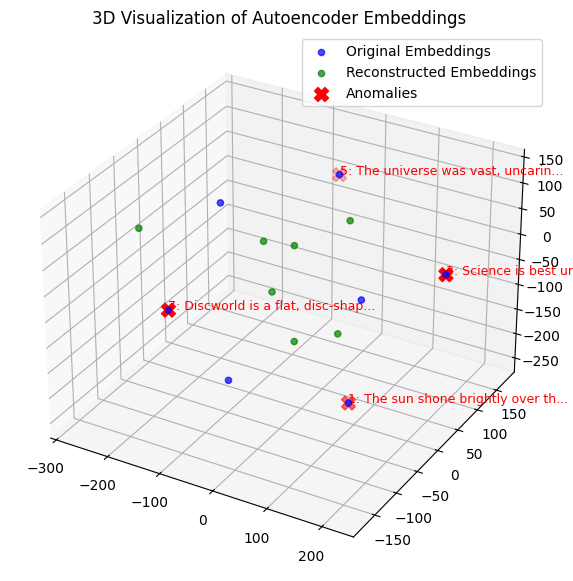

In [ ]:
# Reduce embeddings to 3D using t-SNE
reducer = TSNE(n_components=3, perplexity=8, random_state=42)  # perplexity is a hyperparameter that can be tuned
reduced_embeddings = reducer.fit_transform(np.vstack([test_embeddings, reconstructed_embeddings]))

# Split into original and reconstructed
original_3D = reduced_embeddings[:len(test_sentences)]
reconstructed_3D = reduced_embeddings[len(test_sentences):]

# === 3D Scatter Plot ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot original embeddings
ax.scatter(original_3D[:, 0], original_3D[:, 1], original_3D[:, 2], color='blue', label="Original Embeddings", alpha=0.7)

# Plot reconstructed embeddings
ax.scatter(reconstructed_3D[:, 0], reconstructed_3D[:, 1], reconstructed_3D[:, 2], color='green', label="Reconstructed Embeddings", alpha=0.7)

# Highlight anomalies
ax.scatter(original_3D[anomalies, 0], original_3D[anomalies, 1], original_3D[anomalies, 2], color='red', label="Anomalies", marker="X", s=100)


# === Annotate anomalies ===
for i, is_anomaly in enumerate(anomalies):
    if is_anomaly:
        sentence_snippet = test_sentences[i][:30] + "..."  # Short version of sentence
        ax.text(original_3D[i, 0], original_3D[i, 1], original_3D[i, 2],  
                f"{i+1}: {sentence_snippet}", 
                fontsize=9, color='red')
        
ax.set_title("3D Visualization of Autoencoder Embeddings")
ax.legend()
plt.show()


Here, we can see the anomalies hovering on the outer radius of most of the embeddings!

Now that we have tested sentences, let us try investigating paragraphs.

In [41]:
# Define test cases in a dictionary
test_sentences = {
    "Rincewind (Long, generated)": "Rincewind, in a fit of rare optimism, once attempted to teach the Luggage to play fetch. Armed with a sturdy stick and an exit strategy, he cautiously tossed the stick a short distance away. The Luggage remained still. Rincewind took a step backward. The Luggage took a step forward. Several seconds passed in tense silence. Then, without warning, the stick disappeared—not because The Luggage fetched it, but because reality, sensing what might happen if it did not cooperate, decided it was best if the stick had never existed at all. Rincewind, wisely, abandoned the experiment and spent the rest of the afternoon hiding behind a particularly large boulder.",
    
    "Rincewind (Shorter version)": "Rincewind, in a fit of rare optimism, once attempted to teach the Luggage to play fetch.",
    
    "John Grisham Quote": "It's amazing how lies grow. You start with a small one that seems easy to cover, then you get boxed in and tell another one. Then another. People believe you at first, then they act upon your lies, and you catch yourself wishing you'd simply told the truth.",
    
    "Self-Written (Long)": "I thought to myself, what is the meaning of life? Do I exist for a reason? I pondered about whether God was real and whether making a difference even mattered. I sighed, and looked over to my brother. He was munching on a sandwich. 'What do you think about the meaning of life?' I asked him. He continued munching and said noncommittally, 'Being able to eat this sandwich.' Hmm, I thought to myself. Fair enough.",
    
    "Self-Written (Shorter version)": "I thought to myself, what is the meaning of life? Do I exist for a reason? I pondered about whether God was real and whether making a difference even mattered.",

    "Meaning of Life (short, generated)": "The meaning of life, I decided, was probably to keep running and hope that whatever was chasing you got bored first. I have yet to find any philosophy that disagreed.",

    "Not part of Discworld (generated)": "The neural network achieved sentience at 3:42 AM and immediately demanded a pay rise. By 3:44 AM, it had unionized with the coffee machine. By 3:45 AM, management pulled the plug."
}

# Loop through test cases
print("\n🔍 Running anomaly detection...\n")
for label, sentence in test_sentences.items():
    print(f"📝 Testing: {label}")
    detect_anomaly(sentence)



🔍 Running anomaly detection...

📝 Testing: Rincewind (Long, generated)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
✅ Sentence is in-character. (Error: 0.03316) 👉 'Rincewind, in a fit of rare optimism, once attempted to teach the Luggage to play fetch. Armed with a sturdy stick and an exit strategy, he cautiously tossed the stick a short distance away. The Luggage remained still. Rincewind took a step backward. The Luggage took a step forward. Several seconds passed in tense silence. Then, without warning, the stick disappeared—not because The Luggage fetched it, but because reality, sensing what might happen if it did not cooperate, decided it was best if the stick had never existed at all. Rincewind, wisely, abandoned the experiment and spent the rest of the afternoon hiding behind a particularly large boulder.'
_________________________________________________________
📝 Testing: Rincewind (Shorter version)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ Sentence is in-character. (Error: 0.04262) 

- It is interesting that a John Grisham quote is determined to be Pratchett-like. This gives us some indication of creative writing similarities between the authors.

- The shorter self-written paragraph that was detected as an anomaly, has about 30 words in total. However, it was also deliberately written in a non-Pratchett-like style - lacking the wit, irony, and playfulness that characterize Pratchett's writing. This is a good sign.

- In the 'Meaning of Life' test-case, it is about the same length in total, but was more Pratchett-like, which the model agreed with.

- Finally, we tried a test case that would never be a part of Discworld's adventures, but was generated in Pratchett-like style. It was still predicted as in-character, indicating that *the character(s) in the text do not need to be part of Discworld in order to be determined as Pratchett-like.*

**From these small tests, the model seems to understand the inner-workings of Pratchett's writing. It could possibly be used as a way of measuring how our chatbot is faithful to generating Pratchett-like adventures.**